### A Notebook to convert LDR images to HDR images using Screen and Multiply



In [1]:
import cv2
from PIL import Image
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt

In [2]:
# Read in the image file 

img = cv2.imread('images/LDR.png', 1)

In [3]:
#How many elements are in that data. 
print(img.size)

#What is the shape of the array.
print(img.shape)

#What type are the elements.
print(img.dtype)

#What are the pixel values
print(img[0,0])

399834
(291, 458, 3)
uint8
[213 182 151]


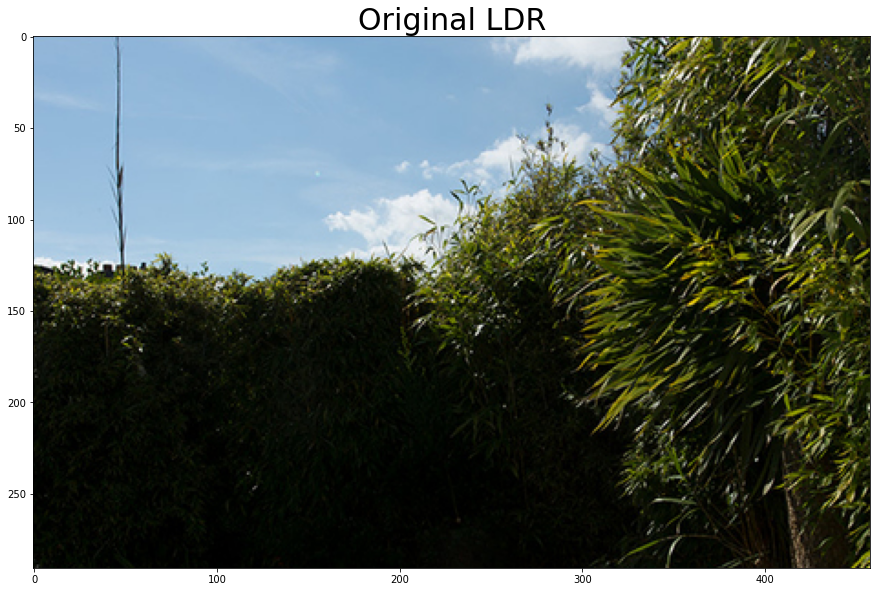

In [6]:
# Draw the image.  Convert from BGR to RGB. 

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize = (15,30))
plt.title('Original LDR', fontdict={'fontsize': 30})
plt.imshow(img)

### To retain highlight information us use the Multiply Blending Mode

Multiply Blend: f(a,b) = a * b

In my implementation both a and b are the same pixel values.  The pixel values must be mapped to (0,1) from (0,255) before performing the transformation.

In [8]:
# Multiply Function

def multiply(img):

    # Save the width, height, and channel depth of the image. 
    h = img.shape[0]
    w = img.shape[1]
    d = img.shape[2]

    # Convert image to a float between 0 and 1.
    img = img.astype("float64") / 255

    # Apply the Filter

    # For each pixel row in the image. 
    for y in range(0,h):
        # For each pixel in the row. x = pixel
        for x in range(0,w):
            # For each RGB value.
            for z in range(0,d):
                # Apply Multiply blend
                img[y,x,z] = img[y,x,z] * img[y,x,z]

    # Convert back to an integer between 0 and 255.
    img = img * 255
    img = np.uint8(img)
    
    # Return Multiply blended image
    return img

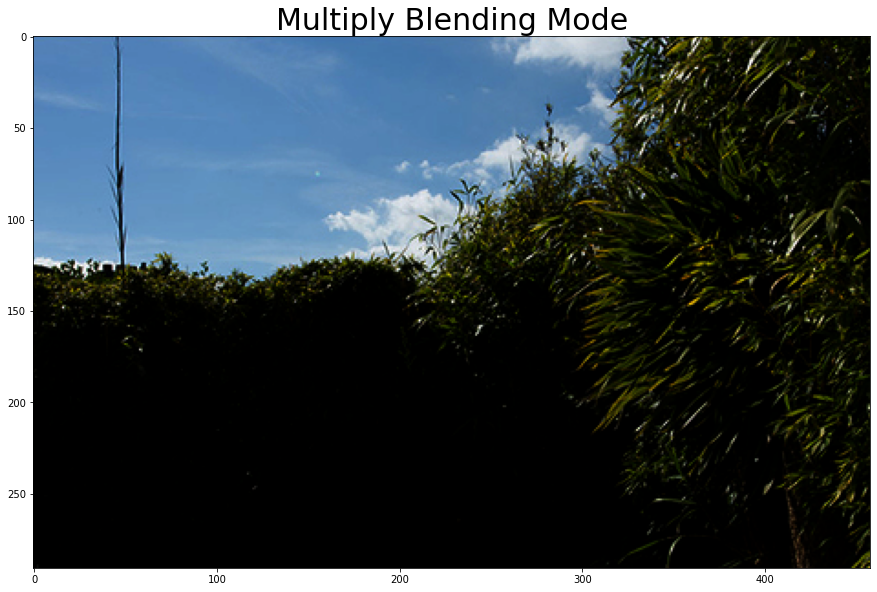

In [9]:
# Multiply the image data to bring back highlight information 

dark = multiply(img)
fig = plt.figure(figsize = (15,30))
plt.title('Multiply Blending Mode', fontdict={'fontsize': 30})
plt.imshow(dark)

### To retain shadow information us use the Screen Blending Mode

Screen Blend: f(a,b) = 1 - (1-a)(1-b)

In my implementation both a and b are the same pixel values.  The pixel values must be mapped to (0,1) from (0,255) before performing the transformation.

In [10]:
# Screen Function

def screen(img):

    # Save the width, height, and channel depth of the image. 
    h = img.shape[0]
    w = img.shape[1]
    d = img.shape[2]

    # Convert image to a float between 0 and 1.
    img = img.astype("float64") / 255

    # Apply the Filter

    # For each pixel row in the image. 
    for y in range(0,h):
        # For each pixel in the row. x = pixel
        for x in range(0,w):
            # For each RGB value.
            for z in range(0,d):
                # Apply Screen blend 
                img[y,x,z] = 1 - (1 - img[y,x,z]) * (1 - img[y,x,z])

     # Convert back to an integer between 0 and 255.
    img = img * 255
    img = np.uint8(img)

    # Return Screen blended image
    return img

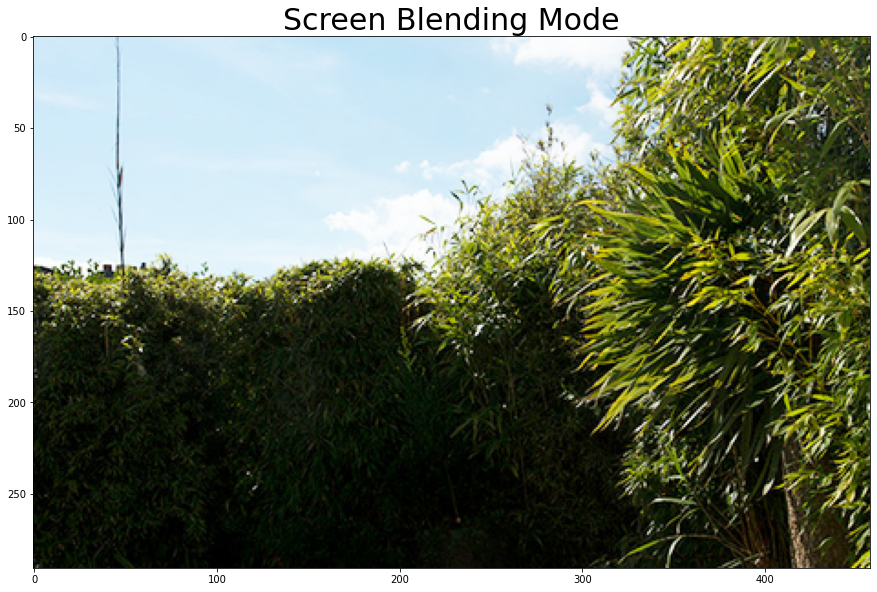

In [11]:
# Screen the image data to bring back shadow information.

light = screen(img)
fig = plt.figure(figsize = (15,30))
plt.title('Screen Blending Mode', fontdict={'fontsize': 30})
plt.imshow(light)

### The following function (blendImg) blends the original LDR, multiply, and screen images together. 

 I calculate the perceived brightness of each pixel to determine if a blending mode should be applied.  If the pixel is in the bottom third of the brightness range a screen blending mode is applied.  If the pixel is in the top third of the the brightness range a multiply blended image is applied.  If the pixel is in the middle third of the brightness range the original LDR pixel values are used.  I also apply an alpha value to the blended image so they are fully used at the darkest and lightest brightness values and then are reduced as they reach the middle tone (middle 1/3) values.

In [32]:
# Blend Screen and Multiply together

def blendImg(img, blendMult, blendScreen):

    # Save the width, height, and channel depth of the image. 
    h = img.shape[0]
    w = img.shape[1]
    d = img.shape[2]

    # Convert images to a float between 0 and 1.
    img = img.astype("float64") / 255
    blendMult = blendMult.astype("float64") / 255
    blendScreen = blendScreen.astype("float64") / 255
    
    # Create a variable for the blended image and set it to the original image. 
    imgBlend = img


     # Apply the Filter

    # For each pixel row in the image. 
    for y in range(0,h):
        # For each pixel in the row. x = pixel
        for x in range(0,w):
            # For each RGB value.
            for z in range(0,d):

                # Perceived brightness
                brightness = (img[y,x,0] * 0.2126) + (img[y,x,1] * 0.7152) + (img[y,x,2] * 0.0722)
                
                # Set a high and low cut off for the multiply (cuttOffHigh) and screen (cuttOffLow) images. 
                cutOffHigh = 2/3
                cutOffLow = 1/3
                
                if(brightness > cutOffHigh):

                    # Calculate an alpha mask so the blending fades out the closer you get to the middle tone (middle 1/3) values.
                    alpha = np.interp(brightness,[cutOffHigh,1],[0,1])

                    # Blend the multiplied image
                    imgBlend[y,x,z] = (img[y,x,z] * (1-alpha)) + (blendMult[y,x,z] * (alpha))

                if(brightness < cutOffLow):

                    # Calculate an alpha mask so the blending fades out the closer you get to the midtone values.
                    alpha = np.interp(brightness,[0,cutOffLow],[1,0])

                    #  Blend the screened image
                    imgBlend[y,x,z] = (img[y,x,z] * (1-alpha)) + (blendScreen[y,x,z] * (alpha))
                
    # Convert back to an integer between 0 and 255.
    imgBlend = imgBlend * 255
    imgBlend = np.uint8(imgBlend)

    # Return the blended image. 
    return imgBlend

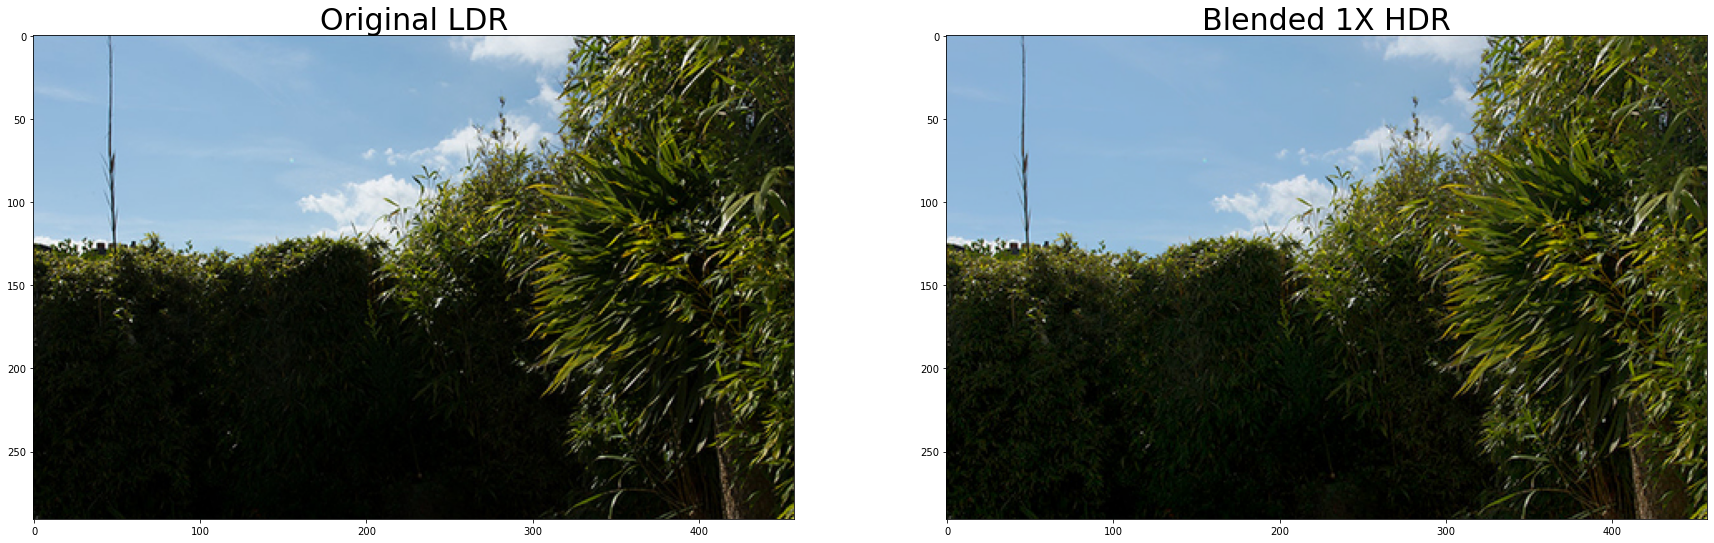

In [33]:
# Create the multiply and screen images
img1 = multiply(img)
img2 = screen(img)

# Blend images together.
blended = blendImg(img, img1, img2)

# Show images. 
fig = plt.figure(figsize = (30,60))
columns = 2
rows = 1
fig.add_subplot(rows,columns, 1)
plt.imshow(img)
plt.title('Original LDR', fontdict={'fontsize': 30})
fig.add_subplot(rows,columns, 2)
plt.imshow(blended)
plt.title('Blended 1X HDR', fontdict={'fontsize': 30})
plt.show()

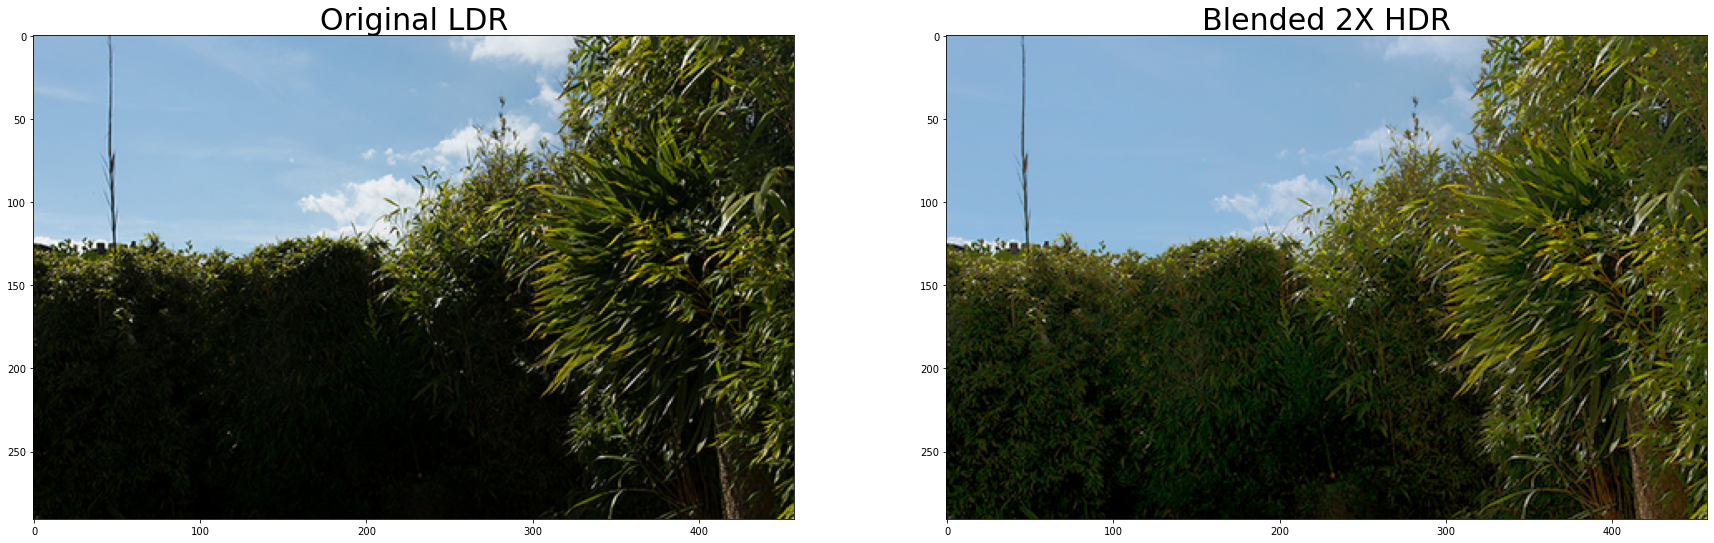

True

In [34]:
# Create the muliply and screen images
img1 = multiply(blended)
img2 = screen(blended)

# Blend images.
blended = blendImg(img, img1, img2)

# Show and save image
fig = plt.figure(figsize = (30,60))
columns = 2
rows = 1
fig.add_subplot(rows,columns, 1)
plt.imshow(img)
plt.title('Original LDR', fontdict={'fontsize': 30})
fig.add_subplot(rows,columns, 2)
plt.imshow(blended)
plt.title('Blended 2X HDR', fontdict={'fontsize': 30})
plt.show()

cv2.imwrite('test1.png', cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))

##  *Notice the increased detail in the shadows of the bushes and the increased detail in the clouds. 

The following histogram shows the transformation of the data at the low and high ends of the brightness range.  The vast majority of the original image data is in the lowest range.  The screen mode moves the data closer to the middle tones and separates the features contained within.  The test image does not contain as much highlight information so it is not as evident on the higher brightness range. 

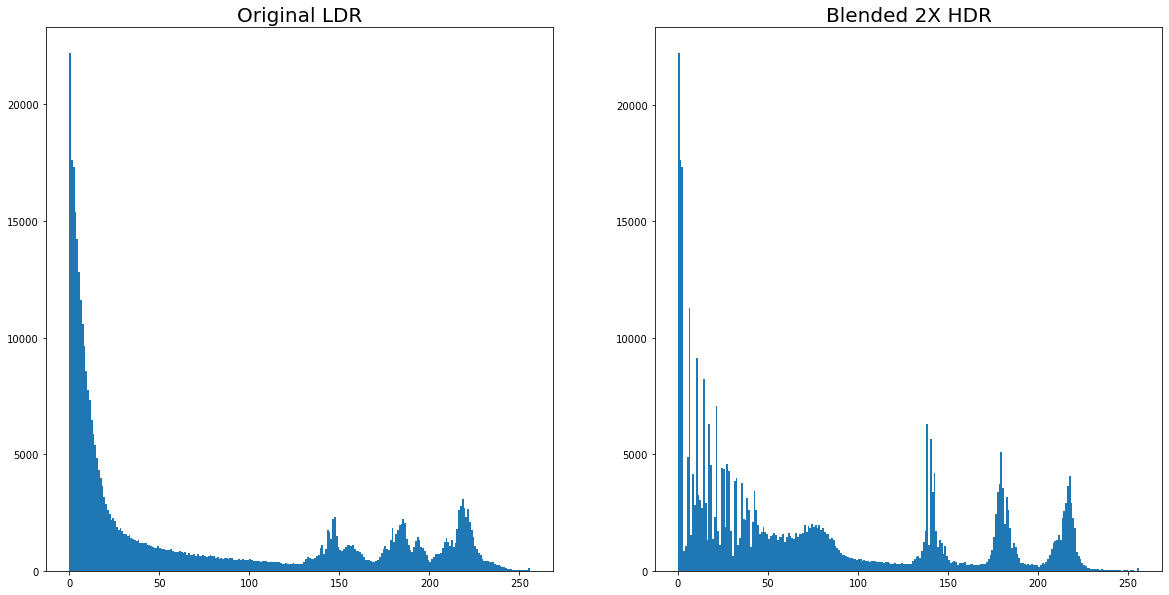

In [35]:
# Show Histogram
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.hist(img.ravel(),256,[0,256])
plt.title('Original LDR', fontdict={'fontsize': 20})
plt.subplot(1,2,2)
plt.hist(blended.ravel(),256,[0,256])
plt.title('Blended 2X HDR', fontdict={'fontsize': 20})
plt.show()


###  Following function is the whole image pipeline

In [48]:
def hdr(img):

    # Save the width, height, and channel depth of the image. 
    h = img.shape[0]
    w = img.shape[1]
    d = img.shape[2]

    # Convert images to a float between 0 and 1.  Create blended images and a copy of the original image. 
    
    blendMult = multiply(img).astype("float64") / 255
    blendScreen = screen(img).astype("float64") / 255
    img = img.astype("float64") / 255
    imgBlend = img

    # For each pixel row in the image. 

    for y in range(0,h):
        # For each pixel in the row. x = pixel
        for x in range(0,w):
            # For each RGB value.
            for z in range(0,d):

                # Preceived brightness 
                brightness = (img[y,x,0] * 0.2126) + (img[y,x,1] * 0.7152) + (img[y,x,2] * 0.0722)
                
                # Set a high and low cut off for the multiply (cuttOffHigh) and screen (cuttOffLow) images. 
                cutOffHigh = 2/3
                cutOffLow = 1/3
                
                if(brightness > cutOffHigh):

                    # Calculate an alpha mask so the blending fades out the closer you get to the midtone values.
                    alpha = np.interp(brightness,[cutOffHigh,1],[0,1])

                    # Blend the mulitplied image
                    imgBlend[y,x,z] = (img[y,x,z] * (1-alpha)) + (blendMult[y,x,z] * (alpha))
                if(brightness < cutOffLow):

                    # Calculate an alpha mask so the blending fades out the closer you get to the midtone values.
                    alpha = np.interp(brightness,[0,cutOffLow],[1,0])

                    #  Blend the screened image
                    imgBlend[y,x,z] = (img[y,x,z] * (1-alpha)) + (blendScreen[y,x,z] * (alpha))
                
    # Convert back to an integer between 0 and 255.
    imgBlend = imgBlend * 255
    imgBlend = np.uint8(imgBlend)


    # Return the blended image. 
    return imgBlend

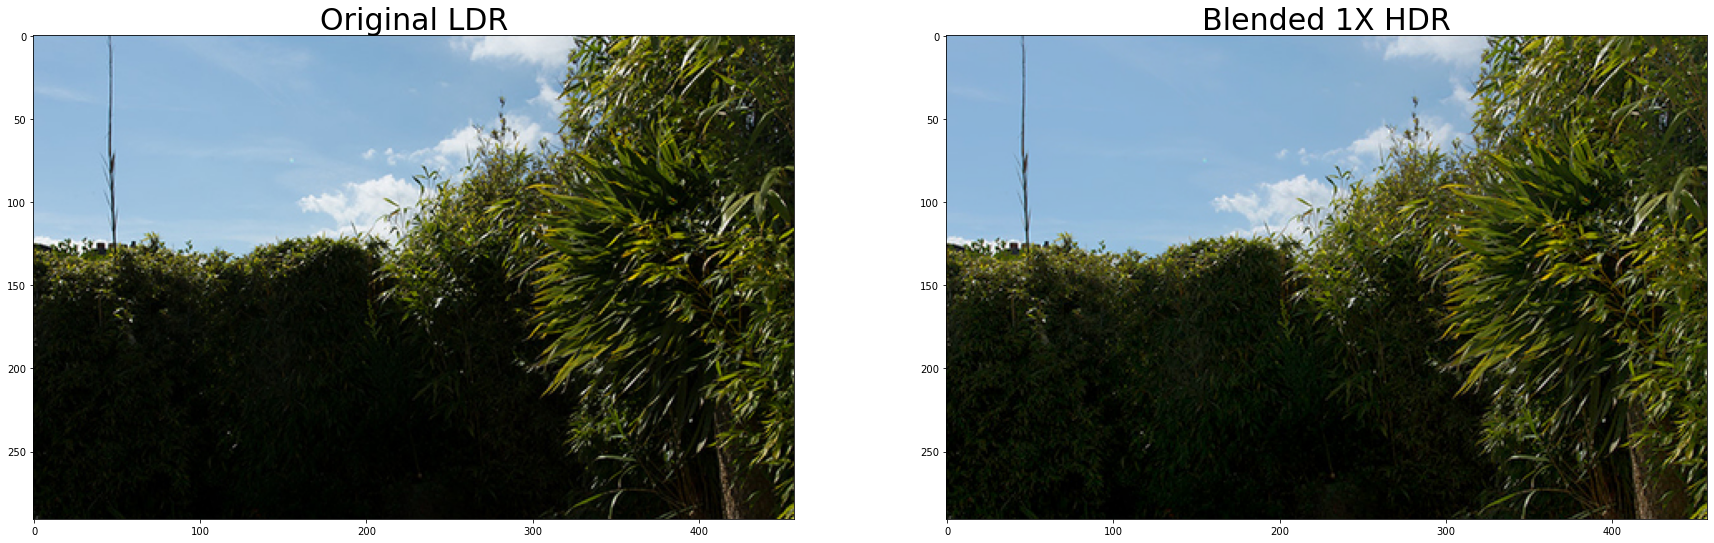

In [10]:
blended = hdr(img)

# Show and save image
fig = plt.figure(figsize = (30,60))
columns = 2
rows = 1
fig.add_subplot(rows,columns, 1)
plt.imshow(img)
plt.title('Original LDR', fontdict={'fontsize': 30})
fig.add_subplot(rows,columns, 2)
plt.imshow(blended)
plt.title('Blended 1X HDR', fontdict={'fontsize': 30})
plt.show()

### Combined the pipeline so it can be imported into any python file or notebook and run with only one image supplied.

Further updates will be to transform the pipeline to a Keras layer so it can be added to the model preprocessing layers. 

In [5]:
# Moved pipeline to seperate python file (hdr_blend.py).   Testing importing and running script. 

from hdr_blend import*

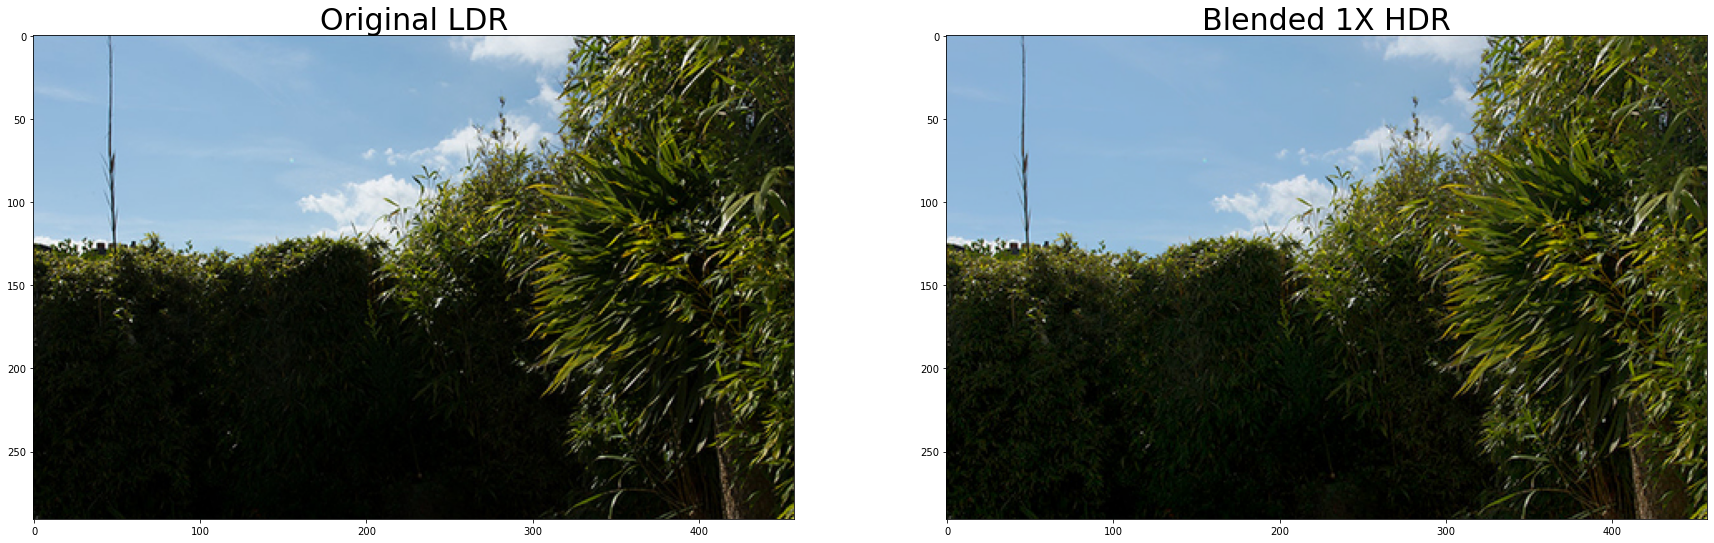

In [9]:
blended = hdr(img)

# Show and save image
fig = plt.figure(figsize = (30,60))
columns = 2
rows = 1
fig.add_subplot(rows,columns, 1)
plt.imshow(img)
plt.title('Original LDR', fontdict={'fontsize': 30})
fig.add_subplot(rows,columns, 2)
plt.imshow(blended)
plt.title('Blended 1X HDR', fontdict={'fontsize': 30})
plt.show()

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow_datasets as tfds
from keras_cv import utils
from keras_cv.layers import BaseImageAugmentationLayer
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [146]:
class RandomBlend(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlend randomly applies a Multiply or Screen Blend to the images.

    Args:
      value_range: value_range: a tuple or a list of two elements. The first value
        represents the lower bound for values in passed images, the second represents
        the upper bound. Images passed to the layer should have values within
        `value_range`.
      factor: A tuple of two floats, a single float or a
        `keras_cv.FactorSampler`. `factor` controls the extent to which the
        image is Blend. `factor=0.0` makes this layer perform a no-op
        operation, while a value of 1.0 uses the degenerated result entirely.
        Values between 0 and 1 result in linear interpolation between the original
        image and the multiply or blended image.
        Values should be between `0.0` and `1.0`.  If a tuple is used, a `factor` is
        sampled between the two values for every image augmented.  If a single float
        is used, a value between `0.0` and the passed float is sampled.  In order to
        ensure the value is always the same, please pass a tuple with two identical
        floats: `(0.5, 0.5)`.
      blend_stack: An interger value that controls the amount of times the image is blended 
        to itself.  A value of 1 allows for the images to be blended once.  In most 
        cases a value of '1' to '3' will give the best results.
    """
    
    def __init__(self, value_range, factor, blend_stack, **kwargs):
        super().__init__(**kwargs)
        self.value_range = value_range
        self.factor = utils.parse_factor(factor)
        self.blend_stack = blend_stack
        self.auto_vectorize = False

    def get_random_transformation(self, **kwargs):
        # kwargs holds {"images": image, "labels": label, etc...}
        return self.factor() 

    def augment_image(self, image, transformation=None, **kwargs):

        # If blend_stack is set to '0' just return the image.
        if(self.blend_stack == 0):
            return image

        # Convert the image to values between '0' and '1'
        image = utils.transform_value_range(image, self.value_range, (0, 1))

        # Get a random value, either '0' or '1', to decide if screen of multiply will be performed. 
        # '0' for multiple. '1' for screen.
        multOrScreen = (np.random.randint(2))
        
        # If '0' perform multiply.
        if(multOrScreen==0):

            augImg = image * image
            # decrement blend_stack
            self.blend_stack = self.blend_stack - 1
            # While there are still more layers to blend.
            while(self.blend_stack > 0):
                augImg = augImg * image
                self.blend_stack = self.blend_stack - 1
            
        #  Else perform screen.
        else:

            augImg = 1 - (1 - image) * (1 - image)
            # decrement blend_stack
            self.blend_stack = self.blend_stack - 1
            # While there are still more layers to blend.
            while(self.blend_stack > 0):
                augImg = 1 - (1 - augImg) * (1 - image)
                self.blend_stack = self.blend_stack - 1

        # Take the augmented image and blend it back with the original.  Transform is the 
        # random value between the two factors supplied by the user.
        image = (augImg * transformation) + (image * (1-transformation))

        # Make sure there is not any image overflow.
        image = tf.clip_by_value(image, 0.0, 1.0)
        
        # Return the image. 
        return image

    def augment_label(self, label, transformation=None, **kwargs):
        return label

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        return bounding_boxes

In [147]:
# Helper function to plot image

def imshow(img):
    img = img.astype(int)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

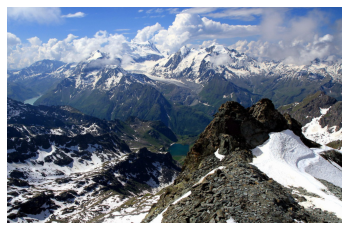

In [148]:
img = cv2.imread('images/img_test.png', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.keras.utils.img_to_array(img)
imshow(img)
img = img / 255

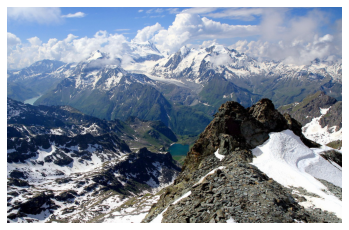

In [155]:
layer = RandomBlend(value_range=(0, 1), factor=(0.1, 1.0), blend_stack=(3))
augmented = layer(img)
imshow((augmented * 255).numpy().astype(int))